In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable balance (production - consommation) :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (consommation et productions pilotées par l'Homme : nucléaire, thermique, hydraulique) et solaire (hypothèse de stabilité dans le temps).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_D.csv',
                usecols = ['Dates', 'Balance'])
df.head(1)

,Dates,Balance
0,2013-01-01,7515.466667


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

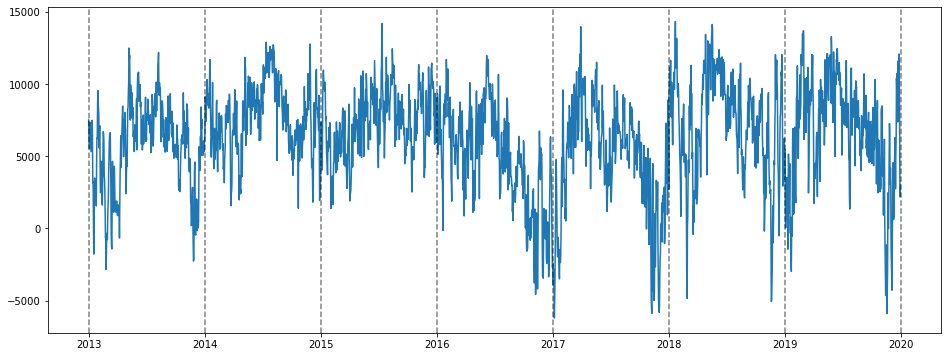

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(df[(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [6]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df)

(-5.547702592419101,
 1.6464975539626794e-06,
 21,
 3204,
 {'1%': -3.4323926176073427,
  '5%': -2.8624425047982394,
  '10%': -2.567250423444633},
 56586.50958043541)

### Coéfficients SARIMAX et saisonnalités

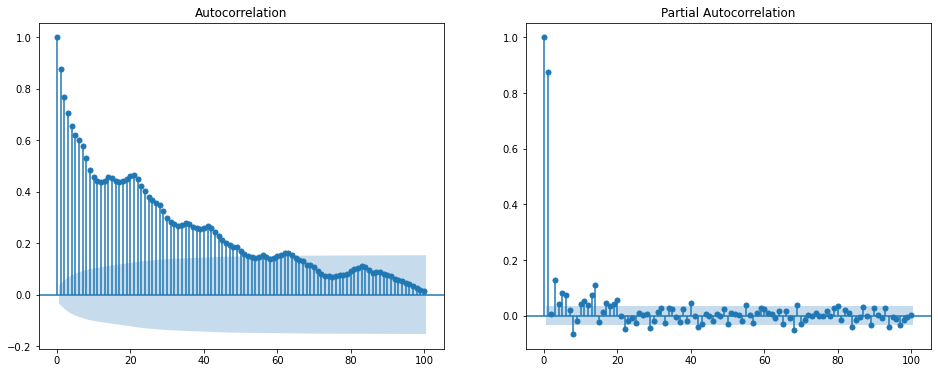

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df, lags = 100, ax=ax1)
plot_pacf(df, lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 7 jours

# Import du dataset filtré (Transformation de Fourier)

In [8]:
df_filtered = pd.read_csv('./dataset/France_D_filtered.csv',
                usecols = ['Dates', 'Balance'])
df_filtered.head(1)

,Dates,Balance
0,2013-01-01,7016.331143


In [9]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [10]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

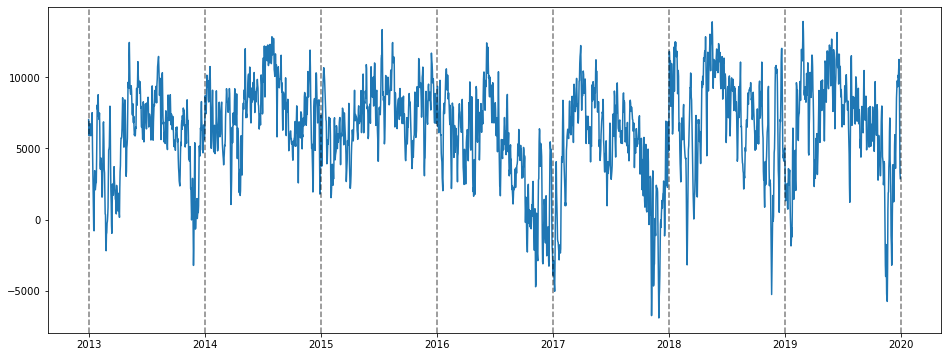

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

# Jeux d'entrainement et de test

In [12]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [13]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [14]:
fenetre = df_test.shape[0]

In [15]:
indice = df_test.index

In [16]:
bilan = df_test

# Paramètres SARIMAX

In [17]:
ordre = (2,0,0)
saison = (0,0,0,7)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [18]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7)
exog['cos_W'] = np.cos(2 * np.pi * exog.index / 7)
# exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25 / 8)
# exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25 / 8)
exog.set_index('date', inplace = True)

In [19]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-20-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

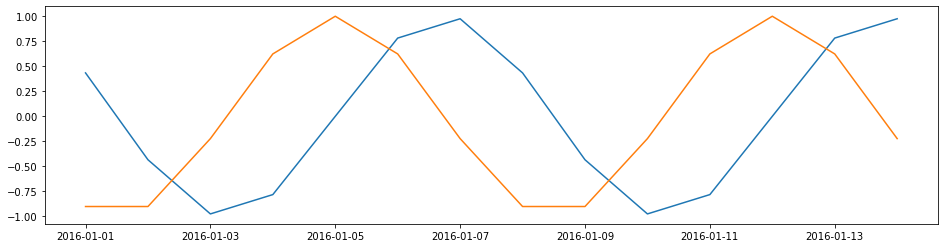

In [20]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [21]:
model_sinus = sm.tsa.SARIMAX(df_train.values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

In [22]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [23]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Bal_p_sinus'], index = indice)

In [24]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [25]:
bilan['Err_sinus'] = np.abs(bilan['Bal_p_sinus'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus
count,670.000000,670.000000,670.000000
mean,5852.513930,6439.779138,3703.210521
std,4153.355930,2867.053286,2944.096437
min,-6110.770833,-2878.405423,8.235407
25%,2909.177083,5159.303204,1315.888920
50%,6323.208333,6550.486639,3060.027616
75%,9289.411458,8374.190013,5360.689521
max,14834.270833,12577.059482,13403.984977


# Régresseurs exogènes : données métier

In [26]:
exog = pd.read_csv('./exog/exog_D_FR.csv', sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01,0.784761,0.54767,0.213699,0.032199


In [27]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [28]:
conso = pd.read_csv('./dataset/France_D.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01,0.784761,0.547670,0.213699,0.032199,54467.220833
2013-01-02,0.885189,0.700377,0.317668,0.072051,64491.541667
2013-01-03,0.877139,0.887473,0.332442,0.057766,66640.916667
2013-01-04,0.887849,0.793175,0.300697,0.038841,65237.479167
2013-01-05,0.875027,0.545293,0.271118,0.041090,60142.125000
...,...,...,...,...,...
2021-10-27,0.702179,2.321462,0.132079,0.144542,53587.895833
2021-10-28,0.718397,2.087944,0.120875,0.141820,53578.229167
2021-10-29,0.701772,1.284362,0.093219,0.070704,52369.687500


In [29]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [30]:
model_exog = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [31]:
result_exog = model_exog.fit(low_memory=True)

In [32]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -21702.487
Date:                Fri, 06 May 2022   AIC                          43420.974
Time:                        08:40:15   BIC                          43467.744
Sample:                             0   HQIC                         43437.935
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           5.09e+04    827.624     61.502      0.000    4.93e+04    5.25e+04
x2          1187.4721     80.136     14.818      0.000    1030.408    1344.536
x3          1.626e+04    621.133     26.172      0.000     1.5e+04    1.75e+04
x4          3005.1746    608.212      4.941      0.000    1813.102    4197.248
x5            -0.6691      0.013    -51.230      0.000      -0.695      -0.643
ar.L1          0.6633      0.020     33.416      0.000       0.624       0.702
ar.L2          0.0457      0.020      2.291      0.022       0.007       0.085
sigma2      1.388e+06   4.03e+04     34.484      0.000    1.31e+06    1.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               297.28
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 8.12e+14. Standard errors may be unstable.
"""

In [33]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [34]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Bal_p_exog'])

In [35]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [36]:
bilan['Err_exog'] = np.abs(bilan['Bal_p_exog'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,5852.513930,6439.779138,3703.210521,6777.289641,3803.557854
std,4153.355930,2867.053286,2944.096437,2936.423811,3038.202687
min,-6110.770833,-2878.405423,8.235407,-2543.088588,3.039606
25%,2909.177083,5159.303204,1315.888920,5355.545281,1380.003761
50%,6323.208333,6550.486639,3060.027616,7019.388537,3033.083227
75%,9289.411458,8374.190013,5360.689521,8749.436820,5881.087783
max,14834.270833,12577.059482,13403.984977,13489.786115,14371.692755


# Régresseurs exogènes : données métier FILTREES

In [37]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01,0.771905,0.548969,0.205676,0.031033


In [38]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [39]:
conso = pd.read_csv('./dataset/France_D_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01,0.771905,0.548969,0.205676,0.031033,59593.969284
2013-01-02,0.880209,0.812805,0.307043,0.059195,61085.083946
2013-01-03,0.877068,0.761847,0.343021,0.070808,62272.424211
2013-01-04,0.893643,0.750889,0.300250,0.047539,63905.489932
2013-01-05,0.873949,0.605144,0.258309,0.036206,62370.384147
...,...,...,...,...,...
2021-10-27,0.703537,2.264806,0.128762,0.156200,53100.318314
2021-10-28,0.725405,2.179541,0.117992,0.140257,54709.672580
2021-10-29,0.704027,1.306633,0.100279,0.077694,53218.450554


In [40]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [41]:
model_filter = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [42]:
result_filter = model_filter.fit(low_memory=True)

In [43]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -22387.192
Date:                Fri, 06 May 2022   AIC                          44790.383
Time:                        08:40:16   BIC                          44837.153
Sample:                             0   HQIC                         44807.344
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.704e+04   1174.182     31.544      0.000    3.47e+04    3.93e+04
x2          -271.0805    102.743     -2.638      0.008    -472.454     -69.707
x3          7711.9568    746.098     10.336      0.000    6249.632    9174.282
x4          6100.2220    817.458      7.462      0.000    4498.034    7702.410
x5            -0.4163      0.017    -23.950      0.000      -0.450      -0.382
ar.L1          0.7779      0.020     39.114      0.000       0.739       0.817
ar.L2         -0.0638      0.020     -3.130      0.002      -0.104      -0.024
sigma2      2.365e+06      4.709   5.02e+05      0.000    2.37e+06    2.37e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                64.80
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 8.75e+19. Standard errors may be unstable.
"""

In [44]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [45]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Bal_p_filter'])

In [46]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [47]:
bilan['Err_exog_filter'] = np.abs(bilan['Bal_p_filter'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,5852.513930,6439.779138,3703.210521,6777.289641,3803.557854,6893.171222,3710.364821
std,4153.355930,2867.053286,2944.096437,2936.423811,3038.202687,2689.124230,2978.048549
min,-6110.770833,-2878.405423,8.235407,-2543.088588,3.039606,-2035.473838,7.096542
25%,2909.177083,5159.303204,1315.888920,5355.545281,1380.003761,5478.937003,1303.506365
50%,6323.208333,6550.486639,3060.027616,7019.388537,3033.083227,7142.311216,3028.940721
75%,9289.411458,8374.190013,5360.689521,8749.436820,5881.087783,8705.133623,5483.586323
max,14834.270833,12577.059482,13403.984977,13489.786115,14371.692755,14313.521838,13785.467393


# Target FILTREE sans régresseur

### SARIMAX

In [48]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter.values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [49]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

In [50]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -21643.225
Date:                Fri, 06 May 2022   AIC                          43292.450
Time:                        08:40:16   BIC                          43309.989
Sample:                             0   HQIC                         43298.810
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3050      0.019     69.763      0.000       1.268       1.342
ar.L2         -0.3243      0.019    -17.336      0.000      -0.361      -0.288
sigma2      1.324e+06    3.7e+04     35.744      0.000    1.25e+06     1.4e+06
===================================================================================
Ljung-Box (L1) (Q):                  30.66   Jarque-Bera (JB):                10.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [51]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [52]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Bal_p_reduit_noreg'])

In [53]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [54]:
bilan['Err_filter_noreg'] = np.abs(bilan['Bal_p_reduit_noreg'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter,Bal_p_reduit_noreg,Err_filter_noreg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,5852.513930,6439.779138,3703.210521,6777.289641,3803.557854,6893.171222,3710.364821,6480.342119,3766.630153
std,4153.355930,2867.053286,2944.096437,2936.423811,3038.202687,2689.124230,2978.048549,2957.296713,2937.108211
min,-6110.770833,-2878.405423,8.235407,-2543.088588,3.039606,-2035.473838,7.096542,-3891.921145,3.189785
25%,2909.177083,5159.303204,1315.888920,5355.545281,1380.003761,5478.937003,1303.506365,5004.485000,1396.559751
50%,6323.208333,6550.486639,3060.027616,7019.388537,3033.083227,7142.311216,3028.940721,6760.113885,3051.696426
75%,9289.411458,8374.190013,5360.689521,8749.436820,5881.087783,8705.133623,5483.586323,8446.109991,5495.192917
max,14834.270833,12577.059482,13403.984977,13489.786115,14371.692755,14313.521838,13785.467393,13069.981500,14652.681368


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [55]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01,0.771905,0.548969,0.205676,0.031033


In [56]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [57]:
conso = pd.read_csv('./dataset/France_D_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01,0.771905,0.548969,0.205676,0.031033,59593.969284
2013-01-02,0.880209,0.812805,0.307043,0.059195,61085.083946
2013-01-03,0.877068,0.761847,0.343021,0.070808,62272.424211
2013-01-04,0.893643,0.750889,0.300250,0.047539,63905.489932
2013-01-05,0.873949,0.605144,0.258309,0.036206,62370.384147
...,...,...,...,...,...
2021-10-27,0.703537,2.264806,0.128762,0.156200,53100.318314
2021-10-28,0.725405,2.179541,0.117992,0.140257,54709.672580
2021-10-29,0.704027,1.306633,0.100279,0.077694,53218.450554


In [58]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [59]:
model_reduit = sm.tsa.SARIMAX(df_train_filter.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [60]:
result_reduit = model_reduit.fit(low_memory=True)

In [61]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -21747.023
Date:                Fri, 06 May 2022   AIC                          43510.045
Time:                        08:40:18   BIC                          43556.815
Sample:                             0   HQIC                         43527.006
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.642e+04   1108.774     32.851      0.000    3.43e+04    3.86e+04
x2          -285.2938     84.160     -3.390      0.001    -450.244    -120.343
x3          7699.5775    619.409     12.431      0.000    6485.558    8913.597
x4          6387.3130    646.657      9.877      0.000    5119.889    7654.737
x5            -0.4078      0.017    -24.283      0.000      -0.441      -0.375
ar.L1          1.0508      0.020     51.839      0.000       1.011       1.090
ar.L2         -0.2856      0.019    -14.794      0.000      -0.323      -0.248
sigma2      1.431e+06   4.94e+04     28.933      0.000    1.33e+06    1.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.54   Jarque-Bera (JB):                 6.12
Prob(Q):                              0.02   Prob(JB):                         0.05
Heteroskedasticity (H):               1.19   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 7.77e+14. Standard errors may be unstable.
"""

In [62]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [63]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Bal_p_reduit'])

In [64]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [65]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Bal_p_reduit'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter,Bal_p_reduit_noreg,Err_filter_noreg,Bal_p_reduit,Err_filter_exog_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,5852.513930,6439.779138,3703.210521,6777.289641,3803.557854,6893.171222,3710.364821,6480.342119,3766.630153,6851.728810,3746.727547
std,4153.355930,2867.053286,2944.096437,2936.423811,3038.202687,2689.124230,2978.048549,2957.296713,2937.108211,2788.126239,2967.044953
min,-6110.770833,-2878.405423,8.235407,-2543.088588,3.039606,-2035.473838,7.096542,-3891.921145,3.189785,-2635.046032,2.597076
25%,2909.177083,5159.303204,1315.888920,5355.545281,1380.003761,5478.937003,1303.506365,5004.485000,1396.559751,5456.698118,1331.863808
50%,6323.208333,6550.486639,3060.027616,7019.388537,3033.083227,7142.311216,3028.940721,6760.113885,3051.696426,7051.183312,3037.713672
75%,9289.411458,8374.190013,5360.689521,8749.436820,5881.087783,8705.133623,5483.586323,8446.109991,5495.192917,8831.464758,5672.210818
max,14834.270833,12577.059482,13403.984977,13489.786115,14371.692755,14313.521838,13785.467393,13069.981500,14652.681368,13947.721967,14463.650199


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [66]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01,0.771905,0.548969,0.205676,0.031033


In [67]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [68]:
conso = pd.read_csv('./dataset/France_D_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01,0.771905,0.548969,0.205676,0.031033,59593.969284
2013-01-02,0.880209,0.812805,0.307043,0.059195,61085.083946
2013-01-03,0.877068,0.761847,0.343021,0.070808,62272.424211
2013-01-04,0.893643,0.750889,0.300250,0.047539,63905.489932
2013-01-05,0.873949,0.605144,0.258309,0.036206,62370.384147
...,...,...,...,...,...
2021-10-27,0.703537,2.264806,0.128762,0.156200,53100.318314
2021-10-28,0.725405,2.179541,0.117992,0.140257,54709.672580
2021-10-29,0.704027,1.306633,0.100279,0.077694,53218.450554


In [69]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [70]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train)
predict_lr = LinReg.predict(exog_test)

In [71]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Bal_p_LinReg'])

In [72]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [73]:
bilan['Err_LinReg'] = np.abs(bilan['Bal_p_LinReg'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter,Bal_p_reduit_noreg,Err_filter_noreg,Bal_p_reduit,Err_filter_exog_filter,Bal_p_LinReg,Err_LinReg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,5852.513930,6439.779138,3703.210521,6777.289641,3803.557854,6893.171222,3710.364821,6480.342119,3766.630153,6851.728810,3746.727547,5210.864944,2379.601295
std,4153.355930,2867.053286,2944.096437,2936.423811,3038.202687,2689.124230,2978.048549,2957.296713,2937.108211,2788.126239,2967.044953,2418.191628,1832.248314
min,-6110.770833,-2878.405423,8.235407,-2543.088588,3.039606,-2035.473838,7.096542,-3891.921145,3.189785,-2635.046032,2.597076,-327.548083,9.818348
25%,2909.177083,5159.303204,1315.888920,5355.545281,1380.003761,5478.937003,1303.506365,5004.485000,1396.559751,5456.698118,1331.863808,3497.770118,945.142104
50%,6323.208333,6550.486639,3060.027616,7019.388537,3033.083227,7142.311216,3028.940721,6760.113885,3051.696426,7051.183312,3037.713672,4949.473621,2039.273156
75%,9289.411458,8374.190013,5360.689521,8749.436820,5881.087783,8705.133623,5483.586323,8446.109991,5495.192917,8831.464758,5672.210818,6924.757467,3360.985666
max,14834.270833,12577.059482,13403.984977,13489.786115,14371.692755,14313.521838,13785.467393,13069.981500,14652.681368,13947.721967,14463.650199,11370.977784,9292.431076


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [74]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01,0.771905,0.548969,0.205676,0.031033


In [75]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [76]:
conso = pd.read_csv('./dataset/France_D_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01,0.771905,0.548969,0.205676,0.031033,59593.969284
2013-01-02,0.880209,0.812805,0.307043,0.059195,61085.083946
2013-01-03,0.877068,0.761847,0.343021,0.070808,62272.424211
2013-01-04,0.893643,0.750889,0.300250,0.047539,63905.489932
2013-01-05,0.873949,0.605144,0.258309,0.036206,62370.384147
...,...,...,...,...,...
2021-10-27,0.703537,2.264806,0.128762,0.156200,53100.318314
2021-10-28,0.725405,2.179541,0.117992,0.140257,54709.672580
2021-10-29,0.704027,1.306633,0.100279,0.077694,53218.450554


In [77]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [78]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter)
predict_lr_filter = LinReg_filter.predict(exog_test)

In [79]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Bal_p_LinReg_filter'])

In [80]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [81]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Bal_p_LinReg_filter'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter,Bal_p_reduit_noreg,Err_filter_noreg,Bal_p_reduit,Err_filter_exog_filter,Bal_p_LinReg,Err_LinReg,Bal_p_LinReg_filter,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,5852.513930,6439.779138,3703.210521,6777.289641,3803.557854,6893.171222,3710.364821,6480.342119,3766.630153,6851.728810,3746.727547,5210.864944,2379.601295,5248.953108,2385.746043
std,4153.355930,2867.053286,2944.096437,2936.423811,3038.202687,2689.124230,2978.048549,2957.296713,2937.108211,2788.126239,2967.044953,2418.191628,1832.248314,2386.674355,1826.826716
min,-6110.770833,-2878.405423,8.235407,-2543.088588,3.039606,-2035.473838,7.096542,-3891.921145,3.189785,-2635.046032,2.597076,-327.548083,9.818348,-233.794964,2.953036
25%,2909.177083,5159.303204,1315.888920,5355.545281,1380.003761,5478.937003,1303.506365,5004.485000,1396.559751,5456.698118,1331.863808,3497.770118,945.142104,3559.562586,936.991882
50%,6323.208333,6550.486639,3060.027616,7019.388537,3033.083227,7142.311216,3028.940721,6760.113885,3051.696426,7051.183312,3037.713672,4949.473621,2039.273156,4971.215399,2054.515520
75%,9289.411458,8374.190013,5360.689521,8749.436820,5881.087783,8705.133623,5483.586323,8446.109991,5495.192917,8831.464758,5672.210818,6924.757467,3360.985666,6941.301764,3368.737923
max,14834.270833,12577.059482,13403.984977,13489.786115,14371.692755,14313.521838,13785.467393,13069.981500,14652.681368,13947.721967,14463.650199,11370.977784,9292.431076,11334.739487,9233.177519


# Visualisation réel vs prédictions

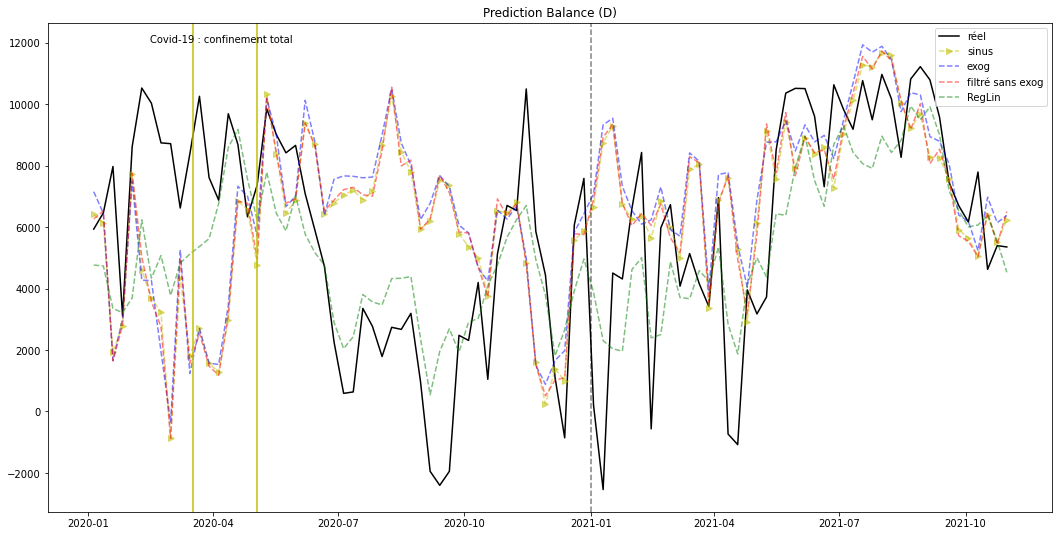

In [85]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Balance'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Bal_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Bal_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
#plt.plot(bilan['Bal_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Bal_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
#plt.plot(bilan['Bal_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Bal_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
#plt.plot(bilan['Bal_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Balance (D)')
plt.axvline(dt.datetime(2021, 1, 1), color = 'k', linestyle = '--', alpha = 0.5)
plt.axvline(dt.datetime(2020, 3, 17), color = 'y')
plt.axvline(dt.datetime(2020, 5, 3), color = 'y')
plt.text(dt.datetime(2020, 2, 15), 12000, 'Covid-19 : confinement total')
plt.savefig('./results/D/pred_balance_D.png');

# Synthèse des erreurs

In [83]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       #'Err_exog_filter',
       'Err_filter_noreg',
       #'Err_filter_exog_filter',
       'Err_LinReg'#,
       #'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_filter_noreg,Err_LinReg
count,670.000000,670.000000,670.000000,670.000000
mean,3703.210521,3803.557854,3766.630153,2379.601295
std,2944.096437,3038.202687,2937.108211,1832.248314
min,8.235407,3.039606,3.189785,9.818348
25%,1315.888920,1380.003761,1396.559751,945.142104
50%,3060.027616,3033.083227,3051.696426,2039.273156
75%,5360.689521,5881.087783,5495.192917,3360.985666
max,13403.984977,14371.692755,14652.681368,9292.431076


In [84]:
bilan.to_csv('./results/D/bilan_balance_D.csv', sep = ';')
erreur.to_csv('./results/D/erreur_balance_D.csv', sep = ';')